# Model Analysis 

This program takes in datasets and models, and computes the loss landscapes over varying amounts of data.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import time
import glob

# Importing our existing funcs
import os
import sys
from pathlib import Path

from minima_volume.dataset_funcs import ( load_models_and_data )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

In [2]:
# User specifies the CIFAR-10 model module name
from minima_volume.models import CIFAR10_CNN_model_data as model_module  # <- your new module for CIFAR-10

# CIFAR-10 CNN initialization parameters
conv_channels = [32, 64, 128]  # adjust as desired
fc_dims = [512, 256]  # adjust as desired

# Grab model - use CNN parameters instead of MLP hidden_dims
model_template = model_module.get_model(
    conv_channels=conv_channels,  # CNN-specific parameter
    fc_dims=fc_dims,              # CNN-specific parameter
    device=device, 
    seed=0
)

# Grab loss and metrics
loss_fn_per_sample = model_module.get_loss_fn_per_sample()

## Loading Model and Datasets

In [3]:
# Get the relative path
target_dir = Path("models_and_data") #current directory

# Lists to store loaded models and additional data
loaded_models, loaded_additional_data, loaded_dataset = load_models_and_data(model_template=model_template, target_dir=target_dir, device="cpu")

# Print dataset information
print(f"Dataset type: {loaded_dataset['dataset_type']}")
print(f"Dataset quantities: {loaded_dataset['dataset_quantities']}")

# Print tensor shapes
print("\nTensor shapes:")
for key in ["x_base_train", "y_base_train", "x_additional", "y_additional", "x_test", "y_test"]:
    if loaded_dataset[key] is not None:
        print(f"  {key}: {loaded_dataset[key].shape}")
    else:
        print(f"  {key}: None")

Looking for models and dataset in: models_and_data
Found 1 model files:
  - model_additional_49950.pt
✅ Model loaded into provided instance from models_and_data\model_additional_49950.pt
Successfully loaded: model_additional_49950.pt

Model data loaded from all models:
Model 0 (model_additional_49950.pt):
  - Additional data: 49950
  - Dataset type: data
  - Training accuracies: 200 entries
  - Test accuracies: 200 entries

Loading dataset...
Using dataset file: dataset.pt


✅ Dataset loaded from models_and_data\dataset.pt
Dataset type: data
Dataset quantities: [0, 450, 1950, 4950, 19950, 49950]

Tensor shapes:
  x_base_train: torch.Size([50, 3, 32, 32])
  y_base_train: torch.Size([50])
  x_additional: torch.Size([49950, 3, 32, 32])
  y_additional: torch.Size([49950])
  x_test: torch.Size([10000, 3, 32, 32])
  y_test: torch.Size([10000])


Base dataset size is  50

Extracted data:
Model 0: Dataset size = 50000, Final test accuracy = 0.7546


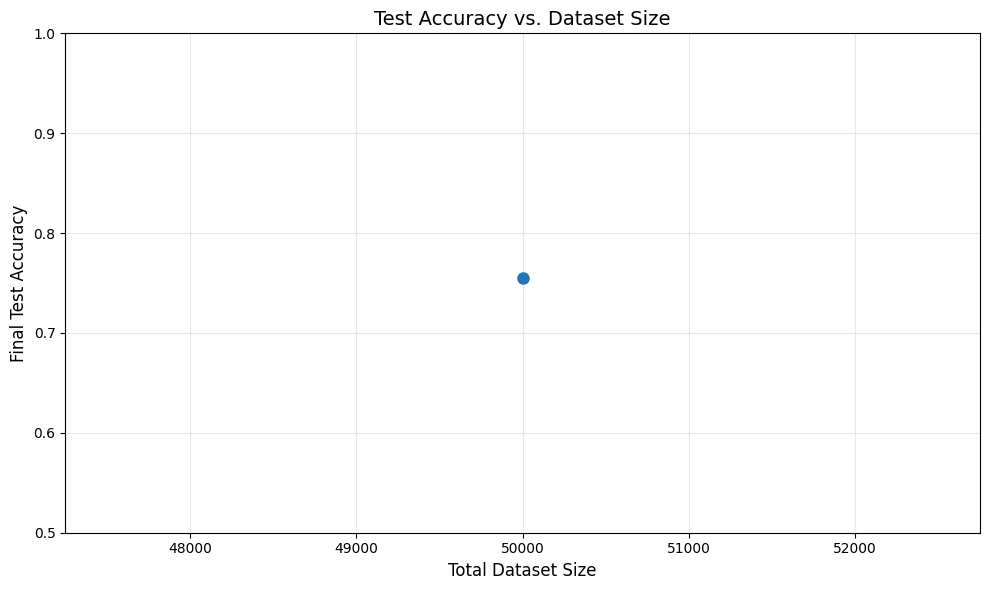


Summary statistics:
Number of models: 1
Dataset sizes range: 50000 to 50000
Accuracy range: 0.7546 to 0.7546
Mean accuracy: 0.7546

Saved data!


In [4]:
base_size = loaded_dataset['x_base_train'].shape[0]
print ("Base dataset size is ", base_size)

# Extract dataset sizes and final test accuracies
dataset_sizes = []
final_test_accuracies = []
for i, model_data in enumerate(loaded_additional_data):
    total_size = base_size + model_data['additional_data']
    final_test_accuracy = model_data['test_accs'][-1]
    dataset_sizes.append(total_size)
    final_test_accuracies.append(final_test_accuracy)

# Convert to numpy arrays for easier manipulation
dataset_sizes = np.array(dataset_sizes)
final_test_accuracies = np.array(final_test_accuracies)

sort_indices = np.argsort(dataset_sizes)
dataset_sizes = dataset_sizes[sort_indices]
final_test_accuracies = final_test_accuracies[sort_indices]

# Print the extracted data
print("\nExtracted data:")
for i, (size, acc) in enumerate(zip(dataset_sizes, final_test_accuracies)):
    print(f"Model {i}: Dataset size = {size}, Final test accuracy = {acc:.4f}")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, final_test_accuracies, 'o-', markersize=8, linewidth=2)

# Customize the plot
plt.xlabel('Total Dataset Size', fontsize=12)
plt.ylabel('Final Test Accuracy', fontsize=12)
plt.title('Test Accuracy vs. Dataset Size', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim((0.5, 1.0))
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print(f"\nSummary statistics:")
print(f"Number of models: {len(dataset_sizes)}")
print(f"Dataset sizes range: {dataset_sizes.min()} to {dataset_sizes.max()}")
print(f"Accuracy range: {final_test_accuracies.min():.4f} to {final_test_accuracies.max():.4f}")
print(f"Mean accuracy: {final_test_accuracies.mean():.4f}")

# Save the arrays to a file
np.savez("test_accuracies.npz", dataset_sizes=dataset_sizes, final_test_accuracies=final_test_accuracies)
print(f"\nSaved data!")